<a href="https://colab.research.google.com/github/michaelsong4399/asteroseismology/blob/yihong/NNFourier3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightkurve
!pip install astroquery
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install pandas
!pip install tensorflow
!pip install astropy

     |████████████████████████████████| 235kB 5.3MB/s 
     |████████████████████████████████| 256kB 7.5MB/s 
     |████████████████████████████████| 788kB 8.3MB/s 
     |████████████████████████████████| 3.4MB 14.8MB/s 
     |████████████████████████████████| 61kB 5.7MB/s 
     |████████████████████████████████| 22.2MB 1.7MB/s 
     |████████████████████████████████| 6.5MB 30.6MB/s 
     |████████████████████████████████| 368kB 37.9MB/s 
     |████████████████████████████████| 25.3MB 1.6MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 3.2MB 36.6MB/s 
  Created wheel for fbpca: filename=fbpca-1.0-cp36-none-any.whl size=11377 sha256=fff944ffab7cf06e192febbdc80e54cfa372609bd41eb99022742be9e7e4a3a8
  Stored in directory: /root/.cache/pip/wheels/53/a2/dd/9b66cf53dbc58cec1e613d216689e5fa946d3e7805c30f60dc
  Created wheel for oktopus: filename=oktopus-0.1.2-cp36-none-any.whl size=12779 sha256=58cfea61067d3e5141c1961275564a5febf045d6f7a9b9edf

In [2]:
import lightkurve as lk
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math
import scipy
import pandas as pd 
from scipy import interpolate
#tf
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Cycles
    #21
        #cycle_21 = []
        
        #Start 1 March 1976
        #End 1 September 1986
        
    #22
        #cycle_22 = [2446674.5,2450296.5]
        
        #Start: 1 September 1986 2446674.5
        #End: 1 August 1996 2450296.5
        
    #23
cycle_23 = [2450296.5,2454801.5]
        
        #Start: 1 August 1996 2450296.5
        #End: 1 December 2008 2454801.5
        
    #24
cycle_24 = [2454801.5,2458940.5]
        
        #Start: 1 December 2008 2454801.5
        #End: 1 May 2020 2458970.5
        #NOTE: Due to dataset limitation, only analyzed up to 2458940.5
        

# Surface Velocity

In [45]:
#hdul = fits.open('data/allsites-alldata-waverage-fill.fits')
hdul = fits.open('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/allsites-alldata-waverage-fill.fits')

hdul.info()

tsdata = hdul[0].data
#         SIMPLE  =                    T / Written by IDL:  Tue Jan 19 11:22:20 2016      
#         BITPIX  =                  -64 /Real*8 (double precision)                       
#         NAXIS   =                    2 /                                                
#         NAXIS1  =                    2 /                                                
#         NAXIS2  =             24455519 /                                                
DSTART =        2442778.50000 #Data start (Julian)      1/1/1976 0:00:00                        
DEND   =        2458940.50000 #Data end (Julian)        4/1/2020 0:00:00                       
#         STATIONS= 'na ca cb su iz la lb mo' /Stations Used                              
#         METHOD  = 'waverage'           /Overlap Method                                  
#         CADENCE = '40      '           /Timeseries Cadence                              
#         N-THRES =                   80 /Noise Rejection Threshold                       
#         GAPFILL =                    1 /GapFill                                         
#         FILL    =             0.638866 /Duty Cycle   
#
#         ~2160 datapoints per day

Filename: /content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/allsites-alldata-waverage-fill.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (2, 34909918)   float64   


In [42]:
def getSV(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,DSTART)
    
    #multiply by 2160 (2160 datapoints per day)
    cycle = np.multiply(cycle,2160)
    
    return tsdata[int(cycle[0]):int(cycle[1])].T[1]

In [7]:
def getSV_index(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,DSTART)
    
    #multiply by 2160 (2160 datapoints per day)
    cycle = np.multiply(cycle,2160)
    
    return tsdata[int(cycle[0]):int(cycle[1])].T[0]

In [8]:
print(getSV(cycle_23))
print(getSV_index(cycle_23))

[ 0.52007627  0.87248993  0.11934945 ...  0.25079036 -1.0275805
 -0.95429337]
[2450296.50033958 2450296.50080254 2450296.50126551 ... 2454801.49915418
 2454801.49961714 2454801.50008011]


# Sunspot Number

In [9]:
#sunspot_Day = np.genfromtxt('data/SN_d_tot_V2.0.csv',delimiter=';')
sunspot_Day = np.genfromtxt('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/SN_d_tot_V2.0.csv',delimiter=';')
SNSTART_Day = 2385070.5
SNEND_day = 2459000.5

#sunspot_Month = np.genfromtxt('data/SN_ms_tot_V2.0.csv',delimiter=';')
sunspot_Month = np.genfromtxt('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/SN_ms_tot_V2.0.csv',delimiter=';')
sunspot_Month = sunspot_Month[828:]

In [10]:
def getSN_Day(cycle):
    if cycle[1] >= SNEND_day:
        cycle[1] = SNEND_day
    cycle = np.subtract(cycle, SNSTART_Day)
    sn = sunspot_Day.T[4][int(cycle[0]):int(cycle[1])]
    
    npout = [[0,0]]
    for i in range(len(sn)):
        npout = np.append(npout,[[i+SNSTART_Day+cycle[0],sn[i]]],0)
    npout = npout[1:]
    return npout

In [11]:
def getSNAverage(cycle,length):
    
    npout = [[0,0]]
    total = 0
    valid_count = 0
    start = cycle[0][0]
    for i in range(len(cycle)):
        if cycle[i][1] >= 0:
            total += cycle[i][1]
            valid_count += 1
        if (i+1) % length < 1 or i == len(cycle)-1:
            if valid_count == 0:
              npout = np.append(npout,[[start,np.average(cycle)]],0)
            else:
              npout = np.append(npout,[[start,total/valid_count]],0)
            total = 0
            valid_count = 0
            if i == len(cycle)-1:
                break
            start = cycle[i+1][0]
    npout = npout[1:]
    return npout

In [12]:
getSN_Day(cycle_23)

array([[2.4502965e+06, 2.6000000e+01],
       [2.4502975e+06, 3.1000000e+01],
       [2.4502985e+06, 3.1000000e+01],
       ...,
       [2.4547985e+06, 0.0000000e+00],
       [2.4547995e+06, 0.0000000e+00],
       [2.4548005e+06, 0.0000000e+00]])

In [13]:
getSNAverage(getSN_Day(cycle_23),365)

array([[2.45029650e+06, 1.45643836e+01],
       [2.45066150e+06, 6.19232877e+01],
       [2.45102650e+06, 1.21704110e+02],
       [2.45139150e+06, 1.69175342e+02],
       [2.45175650e+06, 1.53487671e+02],
       [2.45212150e+06, 1.78747945e+02],
       [2.45248650e+06, 1.29030137e+02],
       [2.45285150e+06, 7.85397260e+01],
       [2.45321650e+06, 5.33808219e+01],
       [2.45358150e+06, 3.17945205e+01],
       [2.45394650e+06, 1.95780822e+01],
       [2.45431150e+06, 6.09041096e+00],
       [2.45467650e+06, 2.98400000e+00]])

# Preprocessing


In [14]:
def getPeriodogram(time,freq):
    lc = lk.LightCurve(time=time.tolist(),flux=freq.tolist())
    lc = lc.remove_nans()
    pg = lc.to_periodogram(method='lombscargle', normalization='psd',minimum_frequency=1000, maximum_frequency=5000)
    #ax = pg.plot()
    pg_data = pg.to_table()
    data = np.array(pg_data['power']).T#.tolist()


    # pg.smooth(method='boxkernel', filter_width=1.)#.plot(ax=ax, label='Smoothed', c='red', lw=2)
    # #ax.axvline(pg.frequency_at_max_power.value, lw=2, ls='dashed')
    # snr = pg.flatten()
    # seis = snr.to_seismology()
    # numax = seis.estimate_numax()
    # numax = float(str(numax)[0:7])
    return data

In [15]:
pg = getPeriodogram(getSV_index(cycle_23)[110000:120000],getSV(cycle_23)[110000:120000])

In [16]:
print(pg[0:5])

[9.43163103e-06 9.01683009e-06 9.53623339e-05 4.53297555e-05
 6.06767015e-05]


In [17]:
#Debug
# time,freq,length,interval = getSV_index(cycle_23),getSV(cycle_23),182.5,91.25

# length = int(length * 2160)
# interval = int(interval * 2160)
# #npout = [[0,0]]
# check = True
# for start in range(0,len(time),interval):
#     if start + length >= len(time):
#         length = len(time) - start
#     if check:
#       check = False
#       npout1d = np.array([getPeriodogram(time[start:start+length],freq[start:start+length])])
#     else:
#       temp = np.array([getPeriodogram(time[start:start+length],freq[start:start+length])])
#       if temp.size == npout1d[-1].size:
#         npout1d = np.append(npout1d,temp,0)
#       else:
#         print(temp.shape,npout1d.shape)
#     print(npout1d.shape)

In [18]:
def tsNumax(time,freq,length,interval):
  length = int(length * 2160)
  interval = int(interval * 2160)
  #npout = [[0,0]]
  check = True
  for start in range(0,len(time),interval):
      if start + length >= len(time):
          length = len(time) - start
      if check:
        check = False
        npout1d = np.array([getPeriodogram(time[start:start+length],freq[start:start+length])])
      else:
        temp = np.array([getPeriodogram(time[start:start+length],freq[start:start+length])])
        if temp.size == npout1d[-1].size:
          npout1d = np.append(npout1d,temp,0)
  return npout1d

In [19]:
#Interpolation
def interpolate(data, smoothness):
    from scipy import interpolate
    x_new = np.linspace((data[0][0])-1,int(data[-1][0])+1,smoothness)
    a_BSpline = interpolate.make_interp_spline(data.T[0],data.T[1])
    y_new = a_BSpline(x_new)
    return x_new,y_new

In [21]:
numax_cycle_23_37 = tsNumax(getSV_index(cycle_23),getSV(cycle_23),182.5,37)

In [22]:
numax_cycle_23_182 = tsNumax(getSV_index(cycle_23),getSV(cycle_23),182.5,91.25)
#print(numax_cycle_23)

In [ ]:
numax_cycle_23_365 = tsNumax(getSV_index(cycle_23),getSV(cycle_23),365,91.25)
#print(numax_cycle_23)

In [23]:
numax_cycle_24_37 = tsNumax(getSV_index(cycle_24),getSV(cycle_24),182.5,37)

In [24]:
numax_cycle_24_182 = tsNumax(getSV_index(cycle_24),getSV(cycle_24),182.5,91.25)

In [ ]:
numax_cycle_24_365 = tsNumax(getSV_index(cycle_24),getSV(cycle_24),365,91.25)
#print(numax_cycle_23)

In [25]:
print(numax_cycle_23_182)

[[2.97696466e-05 8.19987704e-06 1.05384707e-04 ... 3.20928767e-05
  3.64857617e-05 7.95015702e-06]
 [1.89955818e-05 4.13591288e-07 8.07475522e-05 ... 1.53489174e-05
  3.13521866e-05 8.11285198e-06]
 [2.30028433e-05 9.34467566e-05 1.23647725e-04 ... 3.59797493e-06
  1.25009879e-05 2.82519005e-05]
 ...
 [1.96578274e-05 4.02596243e-06 9.75902648e-05 ... 2.66164597e-06
  4.55807005e-05 4.70582693e-05]
 [5.72381487e-06 7.66772419e-05 3.20141675e-06 ... 6.67835719e-06
  3.86473800e-07 1.02447020e-04]
 [5.38898835e-05 1.23581167e-05 6.63245233e-05 ... 6.38514917e-06
  7.26191132e-05 6.05639946e-05]]


# SN

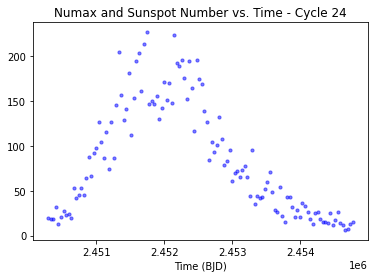

244


In [26]:
data_SN = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_23),0),37)
datax_SN = data_SN.T[0] #np.subtract(data_SN.T[0],200)
datay_SN = data_SN.T[1]

plt.xlabel('Time (BJD)')
plt.title('Numax and Sunspot Number vs. Time - Cycle 24')

#Axis 1
plt.autoscale(enable=True, axis='both', tight=None)
plt.scatter(datax_SN,datay_SN, s = 10, c='blue', alpha=0.5)
plt.show()
print(data_SN.size)


In [27]:
train_x = numax_cycle_23_37
train_y_pre = datay_SN[:-5]
print(train_y_pre)
print(train_x.shape, train_y_pre.shape)
#train_x = np.reshape(train_x, (-1, 2160))
print(train_x.shape)
print(train_x)

# normalize
max = float(np.max(train_y_pre))
train_y = np.divide(train_y_pre,max)
print(np.max(train_y),train_y.shape)

#Train-test set
train_test_x = numax_cycle_24_37
train_test_y = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_24),0),37)[:-5].T[1]
print(train_test_x.shape,train_test_y.shape)

[ 19.52941176  18.5         18.07692308  32.26666667  12.78947368
  20.42105263  27.16666667  23.2         24.19444444  19.5
  52.91666667  42.16216216  45.41666667  53.54054054  45.70588235
  63.83783784  87.27027027  65.94594595  92.64864865  97.40540541
 126.54054054 104.64864865  86.97297297 115.32432432  74.56756757
 126.51351351  86.37837838 145.83783784 204.86486486 157.32432432
 129.16216216 141.32432432 181.40540541 112.56756757 153.78378378
 194.54054054 203.7027027  160.72972973 213.56756757 226.78378378
 146.51351351 150.48648649 147.13513514 156.18918919 130.18918919
 142.21621622 171.81081081 150.75675676 169.97297297 147.54054054
 223.32432432 192.94594595 189.32432432 196.13513514 175.62162162
 152.83783784 195.16216216 164.18918919 116.10810811 195.78378378
 174.48648649 169.59459459 138.67567568 126.91891892  84.13513514
 103.94594595  93.21621622 100.72972973 132.45945946 107.86486486
  78.64864865  82.64864865  94.94594595  60.58333333  69.48648649
  72.37837838  65

In [28]:
tf.test.gpu_device_name()
keras.backend.clear_session()
# model = models.Sequential()

# model.add(layers.Conv1D(1024, 1, activation='relu',batch_input_shape=train_x.shape))
# model.add(layers.Dense(128))
# model.add(layers.Conv1D(32, 1, activation='relu'))
# model.add(layers.Dense(1,activation="sigmoid"))

# model.summary()

model = models.Sequential()
#model.add(layers.Conv1D(filters=16, kernel_size=1, activation='relu', batch_input_shape=(train_x.shape)))

#model.add(layers.Embedding(input_dim=64, output_dim=16))
model.add(layers.Dense(1024, activation='relu', input_shape=(train_x.shape)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 117, 1024)         64586752  
_________________________________________________________________
dense_1 (Dense)              (None, 117, 512)          524800    
_________________________________________________________________
dense_2 (Dense)              (None, 117, 128)          65664     
_________________________________________________________________
dense_3 (Dense)              (None, 117, 16)           2064      
_________________________________________________________________
dense_4 (Dense)              (None, 117, 1)            17        
Total params: 65,179,297
Trainable params: 65,179,297
Non-trainable params: 0
_________________________________________________________________


In [29]:
# model.compile(optimizer='adam',
#              loss='binary_crossentropy',
#              metrics=['accuracy'])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [30]:
history = model.fit(train_x, train_y, epochs=30,
                   validation_data=(train_test_x, train_test_y))

Epoch 1/30
4/4 [==============================] - 4s 687ms/step - loss: 0.1753 - accuracy: 0.0000e+00 - val_loss: 4252.8833 - val_accuracy: 0.0000e+00
Epoch 2/30
4/4 [==============================] - 2s 612ms/step - loss: 0.1000 - accuracy: 0.0149 - val_loss: 4282.7012 - val_accuracy: 0.0000e+00
Epoch 3/30
4/4 [==============================] - 2s 605ms/step - loss: 0.0775 - accuracy: 0.0000e+00 - val_loss: 4275.3203 - val_accuracy: 0.0000e+00
Epoch 4/30
4/4 [==============================] - 2s 592ms/step - loss: 0.0652 - accuracy: 0.0034 - val_loss: 4260.5415 - val_accuracy: 0.0000e+00
Epoch 5/30
4/4 [==============================] - 2s 610ms/step - loss: 0.0516 - accuracy: 0.0086 - val_loss: 4275.9097 - val_accuracy: 0.0000e+00
Epoch 6/30
4/4 [==============================] - 2s 600ms/step - loss: 0.0355 - accuracy: 0.0055 - val_loss: 4269.3652 - val_accuracy: 0.0000e+00
Epoch 7/30
4/4 [==============================] - 2s 597ms/step - loss: 0.0162 - accuracy: 0.0086 - val_loss: 

In [149]:
pred_y = model.predict(train_x)

In [150]:
pred_y = pred_y.reshape(-1)
#pred_y = np.multiply(pred_y,353.0)
print(pred_y)

[0.08393366 0.07866777 0.08956576 0.12376942 0.09143389 0.09208523
 0.10304175 0.10035351 0.10404647 0.11003446 0.22976404 0.20805283
 0.2206594  0.23521376 0.2250312  0.29616383 0.38013807 0.31184536
 0.41439095 0.45050144 0.5667266  0.48125952 0.40350193 0.5069055
 0.35009414 0.5404306  0.40588003 0.6414295  0.9078796  0.6894885
 0.5614081  0.62814885 0.772242   0.52735054 0.6934661  0.8887025
 0.90038687 0.7447559  0.9427212  1.0071747  0.67012006 0.6697994
 0.6697767  0.7037248  0.59699136 0.6340323  0.76205045 0.6984968
 0.75813013 0.684159   0.98538417 0.8864895  0.836825   0.8725888
 0.7671131  0.69697636 0.8651771  0.71854365 0.53951514 0.8592401
 0.79903287 0.74090487 0.62385184 0.56142336 0.39718023 0.4614005
 0.4345654  0.46264178 0.60012156 0.50355333 0.37844795 0.38053292
 0.42359462 0.29952756 0.317459   0.32804835 0.31094855 0.33464637
 0.34074634 0.2810554  0.23155855 0.39456198 0.20605001 0.20113689
 0.19467402 0.20233321 0.23550835 0.2878315  0.31350318 0.22162285
 0.

(117,) (117,) (117,)


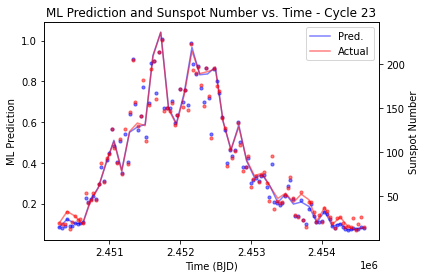

In [152]:
data_SN_23 = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_23),0),37)[:-5]
#data_SN = np.ma.masked_equal(getSN_Day(cycle_23),0)
datax_SN_23 = data_SN_23.T[0] #np.subtract(data_SN.T[0],200)
datay_SN_23 = data_SN_23.T[1]
print(datax_SN_23.shape, datay_SN_23.shape, pred_y.shape)

datax_SN_23_ITP, pred_y_ITP = interpolate(np.array([datax_SN_23,pred_y]).T,40)
datax_SN_23_ITP, datay_SN_23_ITP = interpolate(np.array([datax_SN_23,datay_SN_23]).T,40)

figure, axis_1 = plt.subplots()
plt.xlabel('Time (BJD)')
plt.title('ML Prediction and Sunspot Number vs. Time - Cycle 23')

#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.set_ylabel('ML Prediction')
axis_1.plot(datax_SN_23_ITP, pred_y_ITP, c='blue', alpha=0.5, label = "Pred.")
axis_1.scatter(datax_SN_23,pred_y, s = 10, c='blue', alpha=0.5)

#Axis 2
axis_2 = axis_1.twinx()
axis_2.set_ylabel('Sunspot Number')
axis_2.plot(datax_SN_23_ITP,datay_SN_23_ITP, c='red', alpha=0.5, label = "Actual")
axis_2.scatter(datax_SN_23,datay_SN_23, s = 10, c='red', alpha=0.5)

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
axis_1.legend(lines, labels, loc=0)

#Show Plot
#plt.savefig('Graphs/C23_Numax_SSN_Time.png')
plt.show()

In [153]:
scale_23 = np.max(datay_SN_23)
valid_datay_SN_23 = np.divide(datay_SN_23,scale_23)

In [154]:
print(numax_cycle_24_182)

[[5.12939512e-06 2.74658667e-05 1.30162586e-04 ... 1.87572875e-05
  1.07630421e-04 1.14339673e-05]
 [8.86564049e-06 1.51447890e-05 1.33395100e-04 ... 9.20475404e-05
  6.35275028e-06 3.08707556e-05]
 [7.59165790e-06 4.96486497e-05 1.19273949e-05 ... 1.41437212e-04
  2.59161848e-05 1.19579854e-05]
 ...
 [5.68322111e-06 6.56638822e-05 2.34159817e-05 ... 2.65698299e-05
  9.17601694e-05 1.25909167e-05]
 [3.51589832e-05 2.43807003e-05 2.50134107e-05 ... 9.85385126e-06
  7.86522784e-05 1.88420818e-05]
 [7.53107874e-07 7.63718514e-06 1.56116418e-05 ... 5.53692171e-05
  2.80536905e-05 2.98976611e-05]]


In [137]:

test_x = numax_cycle_24_37
print(test_x.shape)
test_y = model.predict(test_x)
test_y = test_y.reshape(-1)
print(test_y)

(107, 63072)
[0.25718954 0.27154678 0.26526582 0.23617043 0.24023429 0.22249061
 0.23805618 0.25600114 0.24962191 0.2870376  0.24388972 0.2649425
 0.27405596 0.28561443 0.26805955 0.24452311 0.2528139  0.2369869
 0.24259016 0.25211984 0.2601863  0.27441865 0.26868975 0.28045657
 0.28976938 0.31184548 0.30503333 0.34793347 0.3690576  0.33305454
 0.3226664  0.3345709  0.3272885  0.33465207 0.28866303 0.29599756
 0.2883426  0.28981936 0.30322415 0.3119343  0.323162   0.33369446
 0.3165388  0.29458743 0.30580208 0.29981935 0.31366673 0.36798796
 0.38254923 0.39437273 0.39346886 0.4244904  0.3937391  0.37255812
 0.37569556 0.38467056 0.42137486 0.41248876 0.41647983 0.38584524
 0.37250876 0.38861358 0.37444776 0.36033037 0.32096654 0.33390936
 0.34213877 0.3426051  0.33838215 0.35730267 0.32092994 0.31041083
 0.35045797 0.32730383 0.30466214 0.29901594 0.29380342 0.27237195
 0.24741295 0.27090123 0.28654644 0.31904045 0.3358263  0.32426137
 0.32420653 0.3140666  0.27841473 0.2431893  0.2286

(107,) (107,) (107,)


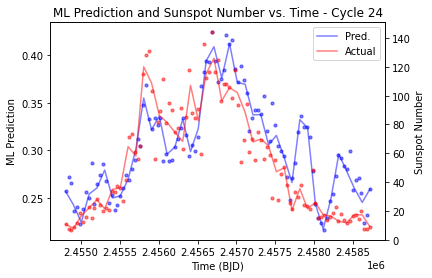

In [155]:
data_SN_24 = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_24),0),37)[:-5]
datax_SN_24 = data_SN_24.T[0] #np.subtract(data_SN.T[0],200)
datay_SN_24 = data_SN_24.T[1]
data2_SN_24 = np.ma.masked_equal(getSN_Day(cycle_24),0)[:-1]
data2x_SN_24 = data2_SN_24.T[0]
data2y_SN_24 = data2_SN_24.T[1]
print(datax_SN_24.shape, datay_SN_24.shape, test_y.shape)

datax_SN_24_ITP, test_y_ITP = interpolate(np.array([datax_SN_24,test_y]).T,40)
datax_SN_24_ITP, datay_SN_24_ITP = interpolate(np.array([datax_SN_24,datay_SN_24]).T,40)

figure, axis_1 = plt.subplots()
plt.xlabel('Time (BJD)')
plt.title('ML Prediction and Sunspot Number vs. Time - Cycle 24')

#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.set_ylabel('ML Prediction')
axis_1.plot(datax_SN_24_ITP, test_y_ITP, c='blue', alpha=0.5, label = "Pred.")
axis_1.scatter(datax_SN_24,test_y, s = 10, c='blue', alpha=0.5)

#Axis 2
axis_2 = axis_1.twinx()
axis_2.set_ylabel('Sunspot Number')
axis_2.plot(datax_SN_24_ITP,datay_SN_24_ITP, c='red', alpha=0.5, label = "Actual")
axis_2.scatter(datax_SN_24,datay_SN_24, s = 10, c='red', alpha=0.5)

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
axis_1.legend(lines, labels, loc=0)

#Show Plot
#plt.savefig('Graphs/C23_Numax_SSN_Time.png')
plt.show()

In [156]:
mse_23 = np.sqrt(mean_squared_error(valid_datay_SN_23,pred_y))
mae_23 = mean_absolute_error(valid_datay_SN_23,pred_y)
print("Cycle 23: Mean Sq. Err, Mean Abs. Err.")
print(round(mse_23,4),round(mae_23,4),round(min(mse_23,mae_23)*scale_23,4))
print()
scale_24 = np.max(datay_SN_24)
valid_datay_SN_24 = np.divide(datay_SN_24,scale_24)
mse_24 = np.sqrt(mean_squared_error(valid_datay_SN_24,test_y))
mae_24 = mean_absolute_error(valid_datay_SN_24,test_y)
print("Cycle 24: Mean Sq. Err, Mean Abs. Err.")
print(round(mse_24,4),round(mae_24,4),round(min(mse_24,mae_24)*scale_24,4))

Cycle 23: Mean Sq. Err, Mean Abs. Err.
0.0184 0.0148 3.3481

Cycle 24: Mean Sq. Err, Mean Abs. Err.
0.237 0.1924 27.7126


# LOI Data

In [70]:
#hdul = fits.open('data/allsites-alldata-waverage-fill.fits')
hdul = fits.open('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/ts_loi.fits')

hdul.info()

loidata = hdul[0].data

# variations at at most 2000 ppm
# cadence: 60s
LOI_DSTART =        2450174.50000 #Data start (Julian)      1 April 1996 0:00:00                        
LOI_DEND   =        2458589.50000 #Data end (Julian)        15 April 2019 0:00:00  

#    #23
# cycle_23 = [2450296.5,2454801.5]
        
#         #Start: 1 August 1996 2450296.5
#         #End: 1 December 2008 2454801.5
        
#     #24
# cycle_24 = [2454801.5,2458940.5]
        
#         #Start: 1 December 2008 2454801.5
#         #End: 1 May 2020 2458970.5


Filename: /content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/ts_loi.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (12117600,)   float64   


In [86]:
#Prepare LOI
loidatax = np.arange(LOI_DSTART,LOI_DEND,1/1440)
print(len(loidatax))
loifull = np.append([loidatax],[loidata],0).T
print(loifull.shape)
print(loifull[200000])

12117600
(12117600, 2)
[ 2.45031339e+06 -2.10748728e-04]


In [87]:
def getLOI(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,LOI_DSTART)
    
    #multiply by 1440 (1440 datapoints per day)
    cycle = np.multiply(cycle,1440)
    
    return loifull[int(cycle[0]):int(cycle[1])]

In [89]:
print(getLOI([2450174.5,2458590.5]).shape)

(12117600, 2)


In [95]:
def tsLOI(time,freq,length,interval):
  length = int(length * 1440)
  interval = int(interval * 1440)
  #npout = [[0,0]]
  check = True
  for start in range(0,len(time),interval):
      if start + length >= len(time):
          length = len(time) - start
      if check:
        check = False
        npout1d = np.array([getPeriodogram(time[start:start+length],freq[start:start+length])])
      else:
        temp = np.array([getPeriodogram(time[start:start+length],freq[start:start+length])])
        if temp.size == npout1d[-1].size:
          npout1d = np.append(npout1d,temp,0)
  return npout1d

In [96]:
LOI_37 = tsLOI(getLOI([2450174.5,2458590.5]).T[0],getLOI([2450174.5,2458590.5]).T[1],182.5,37)

In [97]:
print(LOI_37.shape)

(223, 63072)


In [102]:
print(LOI_37)

[[6.75599211e-13 5.43055508e-13 4.43217376e-13 ... 4.73805527e-14
  2.35625347e-13 2.27213386e-14]
 [4.02580820e-13 1.03647820e-12 1.17410627e-12 ... 2.65607532e-14
  1.68967253e-13 4.45083666e-14]
 [6.62265043e-13 3.48913102e-13 1.77244515e-14 ... 1.37647139e-13
  3.24254467e-14 1.35503333e-13]
 ...
 [2.74580889e-13 5.29345242e-13 4.98513844e-13 ... 1.11057776e-14
  1.66136463e-14 5.00461954e-15]
 [5.27712795e-15 2.09883300e-13 3.47817820e-13 ... 2.48603102e-15
  1.85339429e-15 2.17779476e-14]
 [5.24297422e-13 5.13445652e-13 5.73860651e-14 ... 6.12175773e-15
  1.70744863e-14 7.05726588e-15]]


In [114]:
test_LOI_y = LOI_37[0]
print(test_LOI_y)

[6.75599211e-13 5.43055508e-13 4.43217376e-13 ... 4.73805527e-14
 2.35625347e-13 2.27213386e-14]


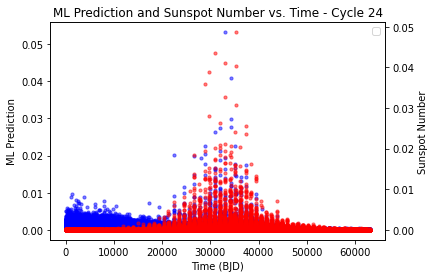

In [115]:
test_LOI_x = np.arange(0,len(test_LOI_y))


figure, axis_1 = plt.subplots()
plt.xlabel('Time (BJD)')
plt.title('ML Prediction and Sunspot Number vs. Time - Cycle 24')

#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.set_ylabel('ML Prediction')
axis_1.scatter(test_LOI_x,np.multiply(test_LOI_y,1250000000), s = 10, c='blue', alpha=0.5)

#Axis 2
axis_2 = axis_1.twinx()
axis_2.set_ylabel('Sunspot Number')
axis_2.scatter(test_LOI_x,train_x[0], s = 10, c='red', alpha=0.5)

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
axis_1.legend(lines, labels, loc=0)

#Show Plot
#plt.savefig('Graphs/C23_Numax_SSN_Time.png')
plt.show()

In [124]:
pred_LOI = model.predict(np.multiply(LOI_37,1250000000))
pred_LOI = pred_LOI.reshape(-1)
print(pred_LOI.shape)

(223,)


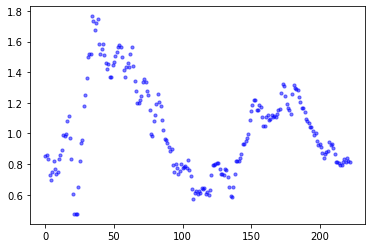

In [117]:
pred_LOI_x = np.arange(0,len(pred_LOI))
plt.autoscale(enable=True, axis='both', tight=None)
plt.scatter(pred_LOI_x,pred_LOI, s = 10, c='blue', alpha=0.5)

#Data Presentation 

In [129]:
#Connect BiSON 23 and 24
BiSON_pred = np.append(pred_y,test_y)
BiSON_pred = BiSON_pred[:-1]
print(BiSON_pred.shape)#,BiSON_pred)

(223,)


In [140]:
#Universal X
datax_SN = np.append(datax_SN_23,datax_SN_24)
datax_SN = datax_SN[:-1]
print(datax_SN.shape)

(223,)


In [158]:
#Universal Sunspot Number
datay_SN = np.append(datay_SN_23,datay_SN_24)
datay_SN = datay_SN[:-1]
print(datay_SN.shape)

(223,)


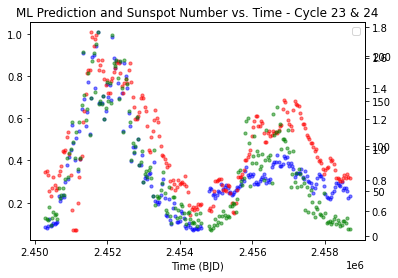

In [167]:
figure, axis_1 = plt.subplots()
plt.xlabel('Time (BJD)')
plt.title('ML Prediction and Sunspot Number vs. Time - Cycle 23 & 24')

#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
#axis_1.set_ylabel('BiSON')
axis_1.scatter(datax_SN,BiSON_pred, s = 10, c='blue', alpha=0.5)

#Axis 2
axis_2 = axis_1.twinx()
#axis_2.set_ylabel('LOI')
axis_2.scatter(datax_SN,pred_LOI, s = 10, c='red', alpha=0.5)

#Axis 3
axis_3 = axis_1.twinx()
#axis_3.set_ylabel('SN')
axis_3.scatter(datax_SN,datay_SN, s = 10, c='green', alpha=0.5)

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
lines_3, labels_3 = axis_3.get_legend_handles_labels()
lines = lines_1 + lines_2 + lines_3
labels = labels_1 + labels_2 + labels_3
axis_1.legend(lines, labels, loc=0)

#Show Plot
#plt.savefig('Graphs/C23_Numax_SSN_Time.png')
plt.show()

In [168]:
scale_total = np.max(datay_SN)
valid_datay_SN = np.divide(datay_SN,scale_total)

In [169]:
BiSON_pred_total = np.max(BiSON_pred)
valid_BiSON_pred = np.divide(BiSON_pred,scale_total)

In [170]:
pred_LOI_total = np.max(pred_LOI)
valid_pred_LOI = np.divide(pred_LOI,scale_total)

In [171]:
BiSONxSN_mse = np.sqrt(mean_squared_error(valid_datay_SN,valid_BiSON_pred))
BiSONxSN_mae = mean_absolute_error(valid_datay_SN,valid_BiSON_pred)
print(BiSONxSN_mse,BiSONxSN_mae)

0.39600919265823803 0.3153416412513468


In [172]:
LOIxSN_mse = np.sqrt(mean_squared_error(valid_datay_SN,valid_pred_LOI))
LOIxSN_mae = mean_absolute_error(valid_datay_SN,valid_pred_LOI)
print(LOIxSN_mse,LOIxSN_mae)

0.3935311685236277 0.312350685269688


In [173]:
BiSONxLOI_mse = np.sqrt(mean_squared_error(valid_BiSON_pred,valid_pred_LOI))
BiSONxLOI_mae = mean_absolute_error(valid_BiSON_pred,valid_pred_LOI)
print(BiSONxLOI_mse,BiSONxLOI_mae)

0.0031015435 0.0029924074
